### Links to Reference

[Keras Multi Output Model](https://github.com/rodrigobressan/keras-multi-output-model-utk-face/blob/master/notebook.ipynb)

[Keras Documentation - Functional API](https://keras.io/guides/functional_api/)

[Stack Overflow - How to Implement Multilabel Classification with UTKFace](https://stackoverflow.com/questions/66852823/how-to-implement-multilabel-classification-on-utkface-dataset-using-tensorflow-a)

[Tensorflow Guide - Keras Train and Evaluate](https://www.tensorflow.org/guide/keras/train_and_evaluate)

[Stack Overflow - Keras Value Error with Dimensions](https://stackoverflow.com/questions/61069068/keras-valueerror-dimensions-must-be-equal-but-are-6-and-9-for-node-equal)

[Helpful Guide for Age + Gender Detection Using DL](https://www.analyticsvidhya.com/blog/2021/07/age-and-gender-detection-using-deep-learning/)

[Keras Model Output Always Same Error](https://github.com/keras-team/keras/issues/6447)

### Imports

In [1]:
# import statements

import os
import pandas as pd
import numpy as np
import glob
import tensorflow as tf
import cv2

### Image Labels
The labels of each face image is embedded in the file name, formated like [age]_[gender]_[race]_[date&time].jpg

**age** is an integer from 0 to 116, indicating the age

**gender** is either 0 (male) or 1 (female)

**race** is an integer from 0 to 4, denoting White, Black, Asian, Indian, and Others (like Hispanic, Latino, Middle Eastern).

**date&time** is in the format of yyyymmddHHMMSSFFF, showing the date and time an image was collected to UTKFace

In [2]:
# dictionaries to convert the numbers from images into their proper labels
dataset_dict = {
    'race_id': {
        0: 'White', 
        1: 'Black', 
        2: 'Asian', 
        3: 'Indian', 
        4: 'Others'
    },
    'gender_id': {
        0: 'Male',
        1: 'Female'
    }
}

# dictionaries to convert the proper labels into numbers 
dataset_dict['gender_alias'] = dict((g, i) for i, g in dataset_dict['gender_id'].items())
dataset_dict['race_alias'] = dict((g, i) for i, g in dataset_dict['race_id'].items())

dataset_dict

{'race_id': {0: 'White', 1: 'Black', 2: 'Asian', 3: 'Indian', 4: 'Others'},
 'gender_id': {0: 'Male', 1: 'Female'},
 'gender_alias': {'Male': 0, 'Female': 1},
 'race_alias': {'White': 0, 'Black': 1, 'Asian': 2, 'Indian': 3, 'Others': 4}}

### Loading Data into Text and CSV Files

In [3]:
# parsing the data set 
def parse_dataset(dataset_path, ext='jpg'):

    def parse_info_from_file(path):
        '''
        Grabbing info from a single file.
        If the file has valid labels, then it returns 
        them as their proper labels using the above 
        dictionaries.
        ''' 
        try:
            filename = os.path.split(path)[1]
            filename = os.path.splitext(filename)[0]
            age, gender, race, _ = filename.split('_')

            return int(age), dataset_dict['gender_id'][int(gender)], dataset_dict['race_id'][int(race)]
        except Exception as ex:
            # if any of the inputs are invalid, then it returns None 
            return None, None, None
        
    files = glob.glob(os.path.join(dataset_path, "*.%s" % ext))
    
    records = []

    '''
    iterating over each file to grab the data and
    place into a dataframe, including age, gender, 
    race, and the file path itself. 
    '''
    for file in files:
        info = parse_info_from_file(file)
        records.append(info)
        
    df = pd.DataFrame(records)
    df['file'] = files
    df.columns = ['Age', 'Gender', 'Race', 'File']
    df = df.dropna()
    
    return df

In [4]:
def parse_dataset_raw(dataset_path, ext='jpg'):

    def parse_raw_info_from_file(path):
        '''
        Grabbing info from a single file.
        If the file has valid labels, then it returns 
        them as their proper labels using the above 
        dictionaries.
        ''' 
        try:
            filename = os.path.split(path)[1]
            filename = os.path.splitext(filename)[0]
            age, gender, race, _ = filename.split('_')

            return int(age), int(gender), int(race)
        except Exception as ex:
            # if any of the inputs are invalid, then it returns None 
            return None, None, None
        
    files = glob.glob(os.path.join(dataset_path, "*.%s" % ext))
    
    records = []

    '''
    iterating over each file to grab the data and
    place into a dataframe, including age, gender, 
    race, and the file path itself. 
    '''
    for file in files:
        info = parse_raw_info_from_file(file)
        records.append(info)
        
    df = pd.DataFrame(records)
    df['file'] = files
    df.columns = ['Age', 'Gender', 'Race', 'File']
    df = df.dropna()
    
    return df

In [5]:
# creating a dataset with the proper labels
dataset_path = "UTKFace"
df = parse_dataset(dataset_path)
df

,Age,Gender,Race,File
0,9.0,Female,Asian,UTKFace/9_1_2_20161219204347420.jpg.chip.jpg
1,36.0,Male,Black,UTKFace/36_0_1_20170117163203851.jpg.chip.jpg
2,86.0,Female,White,UTKFace/86_1_0_20170120225751953.jpg.chip.jpg
3,26.0,Female,White,UTKFace/26_1_0_20170116171048641.jpg.chip.jpg
4,1.0,Female,Asian,UTKFace/1_1_2_20161219154612988.jpg.chip.jpg
...,...,...,...,...
23703,35.0,Male,White,UTKFace/35_0_0_20170117155112202.jpg.chip.jpg
23704,52.0,Male,Indian,UTKFace/52_0_3_20170119200211340.jpg.chip.jpg
23705,26.0,Male,Black,UTKFace/26_0_1_20170116010114628.jpg.chip.jpg
23706,28.0,Male,Black,UTKFace/28_0_1_20170117015458481.jpg.chip.jpg


In [6]:
# dataset with the labels as numbers to feed into the model
df_raw = parse_dataset_raw(dataset_path)
df_raw

,Age,Gender,Race,File
0,9.0,1.0,2.0,UTKFace/9_1_2_20161219204347420.jpg.chip.jpg
1,36.0,0.0,1.0,UTKFace/36_0_1_20170117163203851.jpg.chip.jpg
2,86.0,1.0,0.0,UTKFace/86_1_0_20170120225751953.jpg.chip.jpg
3,26.0,1.0,0.0,UTKFace/26_1_0_20170116171048641.jpg.chip.jpg
4,1.0,1.0,2.0,UTKFace/1_1_2_20161219154612988.jpg.chip.jpg
...,...,...,...,...
23703,35.0,0.0,0.0,UTKFace/35_0_0_20170117155112202.jpg.chip.jpg
23704,52.0,0.0,3.0,UTKFace/52_0_3_20170119200211340.jpg.chip.jpg
23705,26.0,0.0,1.0,UTKFace/26_0_1_20170116010114628.jpg.chip.jpg
23706,28.0,0.0,1.0,UTKFace/28_0_1_20170117015458481.jpg.chip.jpg


In [7]:
# methods to plot data 

import plotly.graph_objects as go
from IPython.display import display, Image

def plot_distribution(pd_series):
    labels = pd_series.value_counts().index.tolist()
    counts = pd_series.value_counts().values.tolist()
    
    pie_plot = go.Pie(labels=labels, values=counts, hole=.3)
    fig = go.Figure(data=[pie_plot])
    fig.update_layout(title_text='Distribution for %s' % pd_series.name)
        
    img = fig.to_image(format="png")
    display(Image(img))

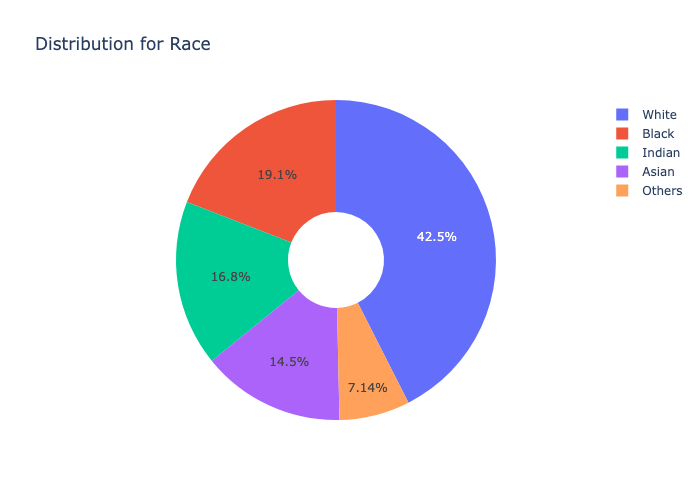

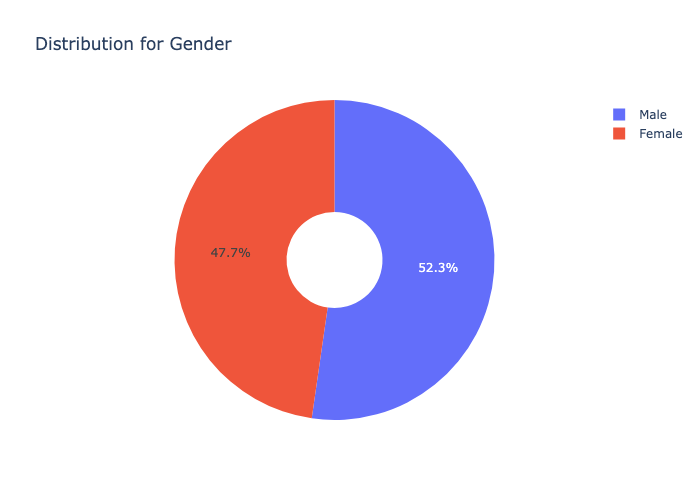

In [8]:
# plotting data for race and gender

plot_distribution(df["Race"])
plot_distribution(df["Gender"])

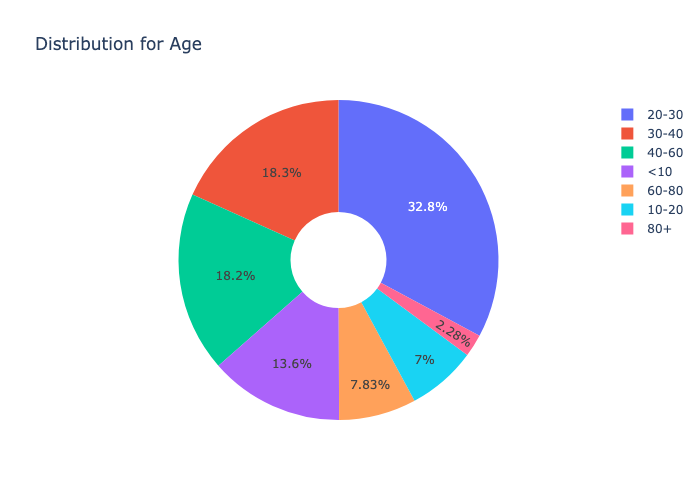

In [9]:
# creating bins for age ranges and plotting that data

bins = [0, 10, 20, 30, 40, 60, 80, np.inf]
names = ['<10', '10-20', '20-30', '30-40', '40-60', '60-80', '80+']

age_binned = pd.cut(df['Age'], bins, labels=names)
plot_distribution(age_binned)


In [10]:
from tensorflow.keras.utils import to_categorical
TRAIN_TEST_SPLIT = 0.80
IM_WIDTH = 48
IM_HEIGHT = 48

class UtkFaceDataGenerator():
    """
    Data generator for the UTKFace dataset. This class should be used when training our Keras multi-output model.
    """
    def __init__(self, df):
        self.df = df
        
    def generate_split_indexes(self):
        p = np.random.permutation(len(self.df))
        train_up_to = int(len(self.df) * TRAIN_TEST_SPLIT)
        train_idx = p[:train_up_to]
        test_idx = p[train_up_to:]

        train_up_to = int(train_up_to * TRAIN_TEST_SPLIT)
        train_idx, valid_idx = train_idx[:train_up_to], train_idx[train_up_to:]
        
        # converts alias to id
        self.df['gender_id'] = self.df['Gender'].map(lambda gender: dataset_dict['gender_alias'][gender])
        self.df['race_id'] = self.df['Race'].map(lambda race: dataset_dict['race_alias'][race])

        self.max_age = self.df['Age'].max()
        
        return train_idx, valid_idx, test_idx
    
    def preprocess_image(self, img_path):
        """
        Used to perform some minor preprocessing with openCV on the image 
        before inputting into the network.
        """
        image = cv2.imread(img_path)
        image = cv2.resize(image,(IM_HEIGHT, IM_WIDTH))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = np.array(image) / 255.0
        
        return image
        
    def generate_images(self, image_idx, is_training, batch_size=16):
        """
        Used to generate a batch with images when training/testing/validating our Keras model.
        """
        
        # arrays to store our batched data
        images, ages, races, genders = [], [], [], []
        while True:
            for idx in image_idx:
                person = self.df.iloc[idx]
                
                age = person['Age']
                race = person['race_id']
                gender = person['gender_id']
                file = person['File']
                
                im = self.preprocess_image(file)
                
                ages.append(age / self.max_age)
                races.append(to_categorical(race, len(dataset_dict['race_id'])))
                genders.append(to_categorical(gender, len(dataset_dict['gender_id'])))
                images.append(im)
                
                # yielding condition
                if len(images) >= batch_size:
                    yield np.array(images), [np.array(ages), np.array(races), np.array(genders)]
                    images, ages, races, genders = [], [], [], []
                    
            if not is_training:
                break
                
data_generator = UtkFaceDataGenerator(df)
train_idx, valid_idx, test_idx = data_generator.generate_split_indexes()

In [11]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Lambda
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Input
import tensorflow as tf

class UtkMultiOutputModel():
    """
    Used to generate our multi-output model. This CNN contains three branches, one for age, other for 
    sex and another for race. Each branch contains a sequence of Convolutional Layers that is defined
    on the make_default_hidden_layers method.
    """
    def make_default_hidden_layers(self, inputs):
        """
        Used to generate a default set of hidden layers. The structure used in this network is defined as:
        
        Conv2D -> BatchNormalization -> Pooling -> Dropout
        """
        x = Conv2D(16, (3, 3), padding="same")(inputs)
        x = Activation("relu")(x)
        x = BatchNormalization(axis=-1)(x)
        x = MaxPooling2D(pool_size=(3, 3))(x)
        x = Dropout(0.25)(x)

        x = Conv2D(32, (3, 3), padding="same")(x)
        x = Activation("relu")(x)
        x = BatchNormalization(axis=-1)(x)
        x = MaxPooling2D(pool_size=(2, 2))(x)
        x = Dropout(0.25)(x)

        x = Conv2D(32, (3, 3), padding="same")(x)
        x = Activation("relu")(x)
        x = BatchNormalization(axis=-1)(x)
        x = MaxPooling2D(pool_size=(2, 2))(x)
        x = Dropout(0.25)(x)

        return x

    def build_race_branch(self, inputs, num_races):
        """
        Used to build the race branch of our face recognition network.
        This branch is composed of three Conv -> BN -> Pool -> Dropout blocks, 
        followed by the Dense output layer.
        """
        x = self.make_default_hidden_layers(inputs)

        x = Flatten()(x)
        x = Dense(128)(x)
        x = Activation("relu")(x)
        x = BatchNormalization()(x)
        x = Dropout(0.5)(x)
        x = Dense(num_races)(x)
        x = Activation("softmax", name="race_output")(x)

        return x

    def build_gender_branch(self, inputs, num_genders=2):
        """
        Used to build the gender branch of our face recognition network.
        This branch is composed of three Conv -> BN -> Pool -> Dropout blocks, 
        followed by the Dense output layer.
        """
        x = Lambda(lambda c: tf.image.rgb_to_grayscale(c))(inputs)

        x = self.make_default_hidden_layers(inputs)

        x = Flatten()(x)
        x = Dense(128)(x)
        x = Activation("relu")(x)
        x = BatchNormalization()(x)
        x = Dropout(0.5)(x)
        x = Dense(num_genders)(x)
        x = Activation("sigmoid", name="gender_output")(x)

        return x

    def build_age_branch(self, inputs):   
        """
        Used to build the age branch of our face recognition network.
        This branch is composed of three Conv -> BN -> Pool -> Dropout blocks, 
        followed by the Dense output layer.

        """
        x = self.make_default_hidden_layers(inputs)

        x = Flatten()(x)
        x = Dense(128)(x)
        x = Activation("relu")(x)
        x = BatchNormalization()(x)
        x = Dropout(0.5)(x)
        x = Dense(1)(x)
        x = Activation("linear", name="age_output")(x)

        return x

    def assemble_full_model(self, width, height, num_races):
        """
        Used to assemble our multi-output model CNN.
        """
        input_shape = (height, width, 3)

        inputs = Input(shape=input_shape)

        age_branch = self.build_age_branch(inputs)
        race_branch = self.build_race_branch(inputs, num_races)
        gender_branch = self.build_gender_branch(inputs)

        model = Model(inputs=inputs,
                     outputs = [age_branch, race_branch, gender_branch],
                     name="face_net")

        return model
    
model = UtkMultiOutputModel().assemble_full_model(IM_HEIGHT, IM_WIDTH, num_races=len(dataset_dict['race_alias']))

Metal device set to: Apple M1

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB



2022-07-18 22:55:53.157308: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-07-18 22:55:53.157435: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [12]:
model.summary()

Model: "face_net"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 48, 48, 3)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 48, 48, 16)   448         ['input_1[0][0]']                
                                                                                                  
 conv2d_3 (Conv2D)              (None, 48, 48, 16)   448         ['input_1[0][0]']                
                                                                                                  
 conv2d_6 (Conv2D)              (None, 48, 48, 16)   448         ['input_1[0][0]']                
                                                                                           

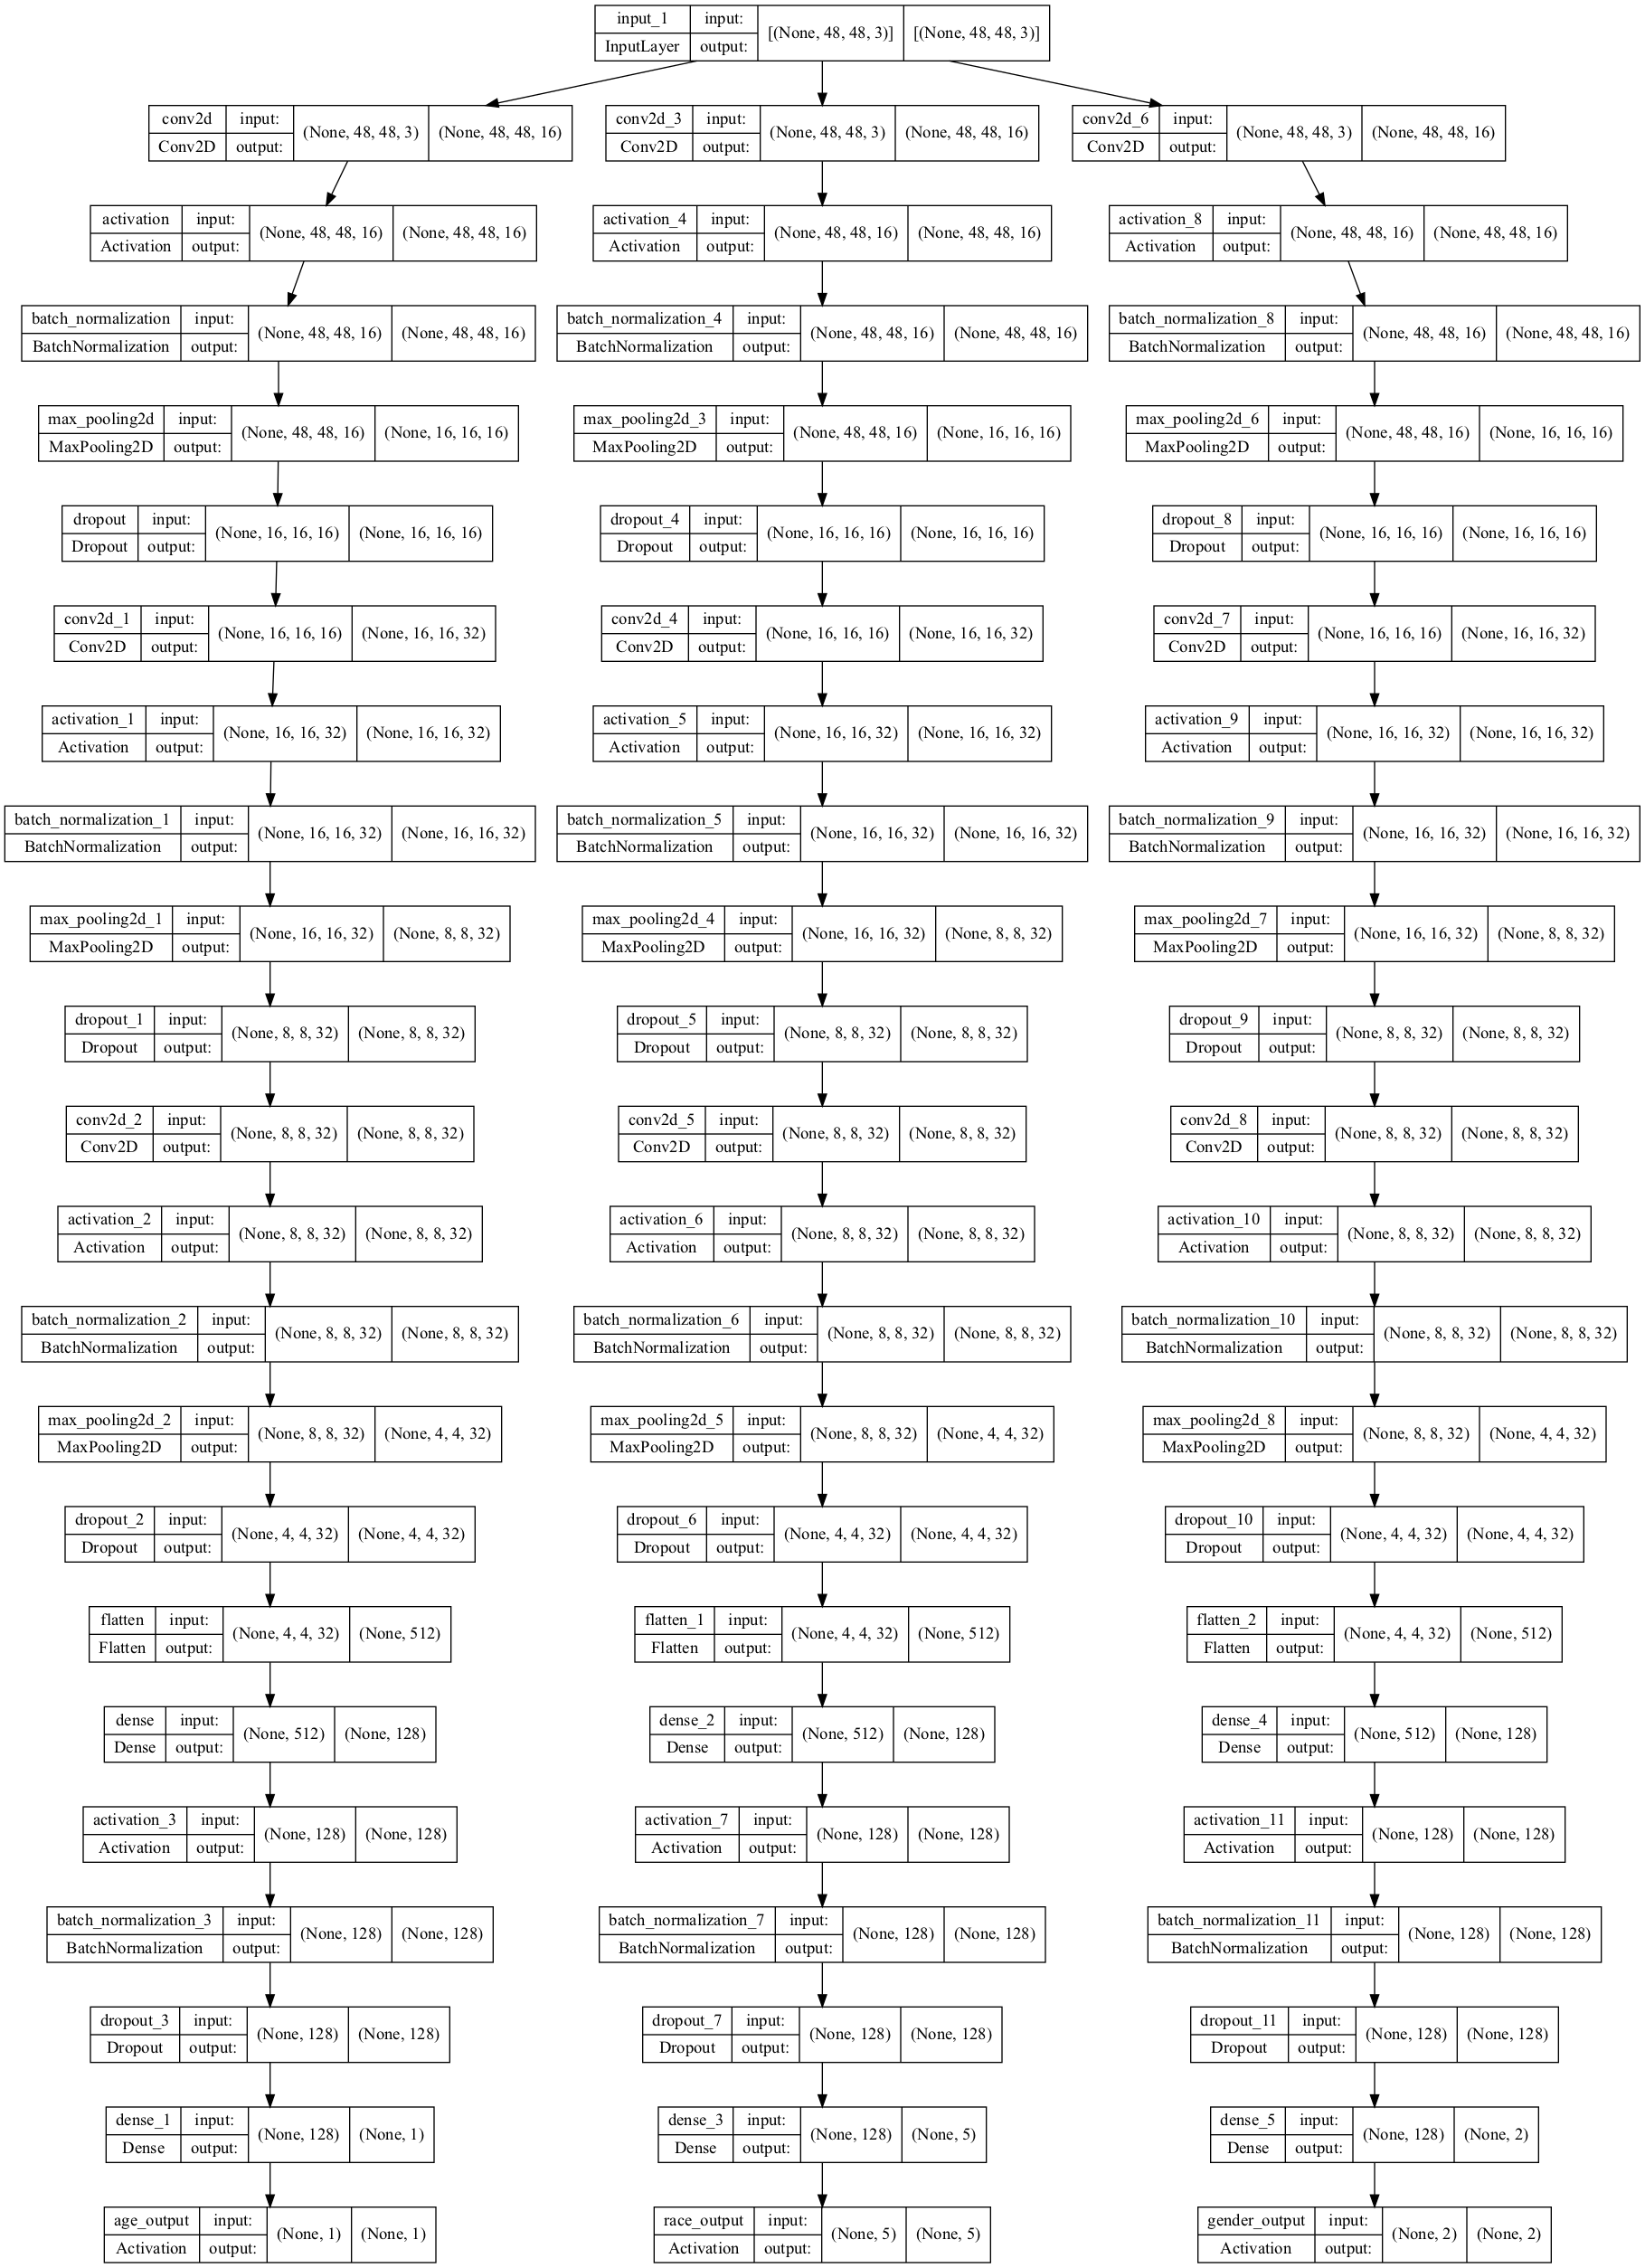

In [13]:
# showing the visualization of the model generated

dot_img_file = 'model-images/new-model.png'
tf.keras.utils.plot_model(model, to_file=dot_img_file, show_shapes=True)

In [14]:
# compiling the model and setting learning rate, optimizer, epochs, and loss functions
from tensorflow.keras.optimizers import Adam

init_lr = 1e-4
epochs = 150

opt = Adam(learning_rate=init_lr, decay=init_lr / epochs)

model.compile(optimizer=opt, 
              loss={
                  'age_output': 'mse', 
                  'race_output': 'categorical_crossentropy', 
                  'gender_output': 'binary_crossentropy'},
              loss_weights={
                  'age_output': 4., 
                  'race_output': 1.5, 
                  'gender_output': 0.1},
              metrics={
                  'age_output': 'mae', 
                  'race_output': 'accuracy',
                  'gender_output': 'accuracy'})


In [15]:
# fitting the model with the train and test data
from tensorflow.keras.callbacks import ModelCheckpoint

batch_size = 32
valid_batch_size = 32
train_gen = data_generator.generate_images(train_idx, is_training=True, batch_size=batch_size)
valid_gen = data_generator.generate_images(valid_idx, is_training=True, batch_size=valid_batch_size)

callbacks = [ModelCheckpoint("./model_checkpoint", monitor='val_loss')]

History = model.fit(train_gen,
                    steps_per_epoch=len(train_idx)//batch_size,
                    epochs=epochs,
                    callbacks=callbacks,
                    validation_data=valid_gen,
                    validation_steps=len(valid_idx)//valid_batch_size)


Epoch 1/150


2022-07-18 22:55:54.959435: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-07-18 22:55:56.016949: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


474/474 [==============================] - ETA: 0s - loss: 11.3163 - age_output_loss: 2.0230 - race_output_loss: 2.0962 - gender_output_loss: 0.7974 - age_output_mae: 1.1007 - race_output_accuracy: 0.3155 - gender_output_accuracy: 0.6157

2022-07-18 22:56:14.731470: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-07-18 22:56:17.984593: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: ./model_checkpoint/assets
474/474 [==============================] - 27s 52ms/step - loss: 11.3163 - age_output_loss: 2.0230 - race_output_loss: 2.0962 - gender_output_loss: 0.7974 - age_output_mae: 1.1007 - race_output_accuracy: 0.3155 - gender_output_accuracy: 0.6157 - val_loss: 3.8540 - val_age_output_loss: 0.3800 - val_race_output_loss: 1.5120 - val_gender_output_loss: 0.6590 - val_age_output_mae: 0.4763 - val_race_output_accuracy: 0.4534 - val_gender_output_accuracy: 0.6239
Epoch 2/150
474/474 [==============================] - 24s 51ms/step - loss: 6.4435 - age_output_loss: 0.9704 - race_output_loss: 1.6649 - gender_output_loss: 0.6457 - age_output_mae: 0.7641 - race_output_accuracy: 0.4166 - gender_output_accuracy: 0.6984 - val_loss: 2.7971 - val_age_output_loss: 0.1876 - val_race_output_loss: 1.3225 - val_gender_output_loss: 0.6306 - val_age_output_mae: 0.3376 - val_race_output_accuracy: 0.4889 - val_gender_output_accuracy: 0.6623
Epoch 3/150


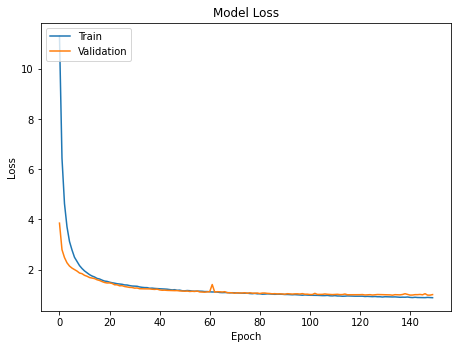

In [16]:
# model loss 

import matplotlib.pyplot as plt

plt.plot(History.history['loss'])
plt.plot(History.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.subplots_adjust(top=1.00, bottom=0.0, left=0.0, right=0.95, hspace=0.25,
                        wspace=0.35)

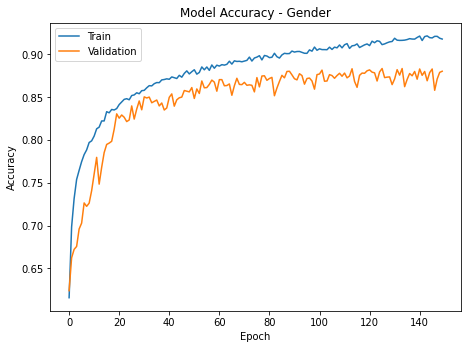

In [17]:
# gender accuracy 

plt.plot(History.history['gender_output_accuracy'])
plt.plot(History.history['val_gender_output_accuracy'])
plt.title('Model Accuracy - Gender')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.subplots_adjust(top=1.00, bottom=0.0, left=0.0, right=0.95, hspace=0.25,
                        wspace=0.35)

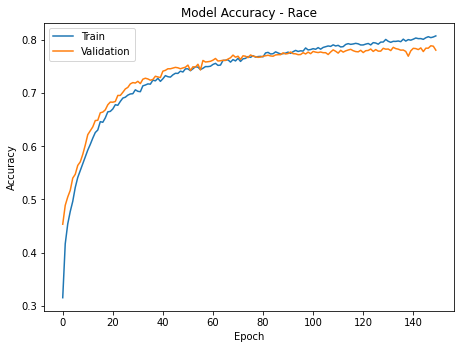

In [18]:
# race accuracy

plt.plot(History.history['race_output_accuracy'])
plt.plot(History.history['val_race_output_accuracy'])
plt.title('Model Accuracy - Race')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.subplots_adjust(top=1.00, bottom=0.0, left=0.0, right=0.95, hspace=0.25,
                        wspace=0.35)

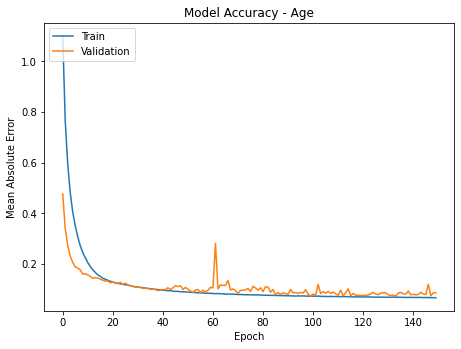

In [19]:
# age mean absolute error 

plt.plot(History.history['age_output_mae'])
plt.plot(History.history['val_age_output_mae'])
plt.title('Model Accuracy - Age')
plt.ylabel('Mean Absolute Error')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.subplots_adjust(top=1.00, bottom=0.0, left=0.0, right=0.95, hspace=0.25,
                        wspace=0.35)

In [20]:
import tensorflow as tf 

Model = tf.keras.models.load_model("./model_checkpoint")

In [21]:
import matplotlib.pyplot as plt
import plotly.graph_objects as go

plt.clf()
fig = go.Figure()
fig.add_trace(go.Scatter(
                    y=History.history['race_output_accuracy'],
                    name='Train'))

fig.add_trace(go.Scatter(
                    y=History.history['val_race_output_accuracy'],
                    name='Valid'))


fig.update_layout(height=450, 
                  width=600,
                  title='Accuracy For Race Feature',
                  xaxis_title='Epoch',
                  yaxis_title='Accuracy')

fig.write_html('acc_race.html', include_plotlyjs='cdn')

fig.show()


<Figure size 432x288 with 0 Axes>

In [22]:
plt.clf()
fig = go.Figure()
fig.add_trace(go.Scatter(
                    y=History.history['gender_output_accuracy'],
                    name='Train'))

fig.add_trace(go.Scatter(
                    y=History.history['val_gender_output_accuracy'],
                    name='Valid'))


fig.update_layout(height=450, 
                  width=600,
                  title='Accuracy For Gender Feature',
                  xaxis_title='Epoch',
                  yaxis_title='Accuracy')

fig.write_html('acc_race.html', include_plotlyjs='cdn')

fig.show()


<Figure size 432x288 with 0 Axes>

In [23]:
plt.clf()
fig = go.Figure()
fig.add_trace(go.Scatter(
                    y=History.history['age_output_mae'],
                    name='Train'))

fig.add_trace(go.Scatter(
                    y=History.history['val_age_output_mae'],
                    name='Valid'))


fig.update_layout(height=450, 
                  width=600,
                  title='Accuracy For Age Feature - Mean Absolute Error',
                  xaxis_title='Epoch',
                  yaxis_title='Accuracy')

fig.write_html('acc_race.html', include_plotlyjs='cdn')

fig.show()


<Figure size 432x288 with 0 Axes>

In [24]:
plt.clf()
fig = go.Figure()
fig.add_trace(go.Scatter(
                    y=History.history['loss'],
                    name='Train'))

fig.add_trace(go.Scatter(
                    y=History.history['val_loss'],
                    name='Valid'))


fig.update_layout(height=450, 
                  width=600,
                  title='Overall Loss',
                  xaxis_title='Epoch',
                  yaxis_title='Accuracy')

fig.write_html('acc_race.html', include_plotlyjs='cdn')

fig.show()


<Figure size 432x288 with 0 Axes>

In [25]:
test_batch_size = 128
test_generator = data_generator.generate_images(test_idx, is_training=False, batch_size=test_batch_size)
age_pred, race_pred, gender_pred = model.predict_generator(test_generator, 
                                                           steps=len(test_idx)//test_batch_size)

/var/folders/5q/ksg3mt4j6nj74_83sysnf1tm0000gn/T/ipykernel_17457/3216382709.py:3: UserWarning:

`Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.

2022-07-19 00:00:37.614811: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


In [26]:
test_generator = data_generator.generate_images(test_idx, is_training=False, batch_size=test_batch_size)
samples = 0
images, age_true, race_true, gender_true = [], [], [], []
for test_batch in test_generator:
    image = test_batch[0]
    labels = test_batch[1]
    
    images.extend(image)
    age_true.extend(labels[0])
    race_true.extend(labels[1])
    gender_true.extend(labels[2])
    
age_true = np.array(age_true)
race_true = np.array(race_true)
gender_true = np.array(gender_true)

race_true, gender_true = race_true.argmax(axis = -1), gender_true.argmax(axis = -1)
race_pred, gender_pred = race_pred.argmax(axis = -1), gender_pred.argmax(axis = -1)

age_true = age_true * data_generator.max_age
age_pred = age_pred * data_generator.max_age

In [27]:
from sklearn.metrics import classification_report

cr_race = classification_report(race_true, race_pred, target_names=dataset_dict['race_alias'].keys())
print(cr_race)

              precision    recall  f1-score   support

       White       0.84      0.86      0.85      2005
       Black       0.79      0.89      0.84       937
       Asian       0.79      0.78      0.78       640
      Indian       0.71      0.79      0.74       820
      Others       0.39      0.08      0.13       334

    accuracy                           0.79      4736
   macro avg       0.70      0.68      0.67      4736
weighted avg       0.77      0.79      0.77      4736



In [28]:
cr_gender = classification_report(gender_true, gender_pred, target_names=dataset_dict['gender_alias'].keys())
print(cr_gender)

              precision    recall  f1-score   support

        Male       0.94      0.83      0.88      2468
      Female       0.84      0.94      0.89      2268

    accuracy                           0.88      4736
   macro avg       0.89      0.89      0.88      4736
weighted avg       0.89      0.88      0.88      4736



In [29]:
from sklearn.metrics import r2_score

print('R2 score for Age: ', r2_score(age_true, age_pred))

R2 score for Age:  0.6269266615487763


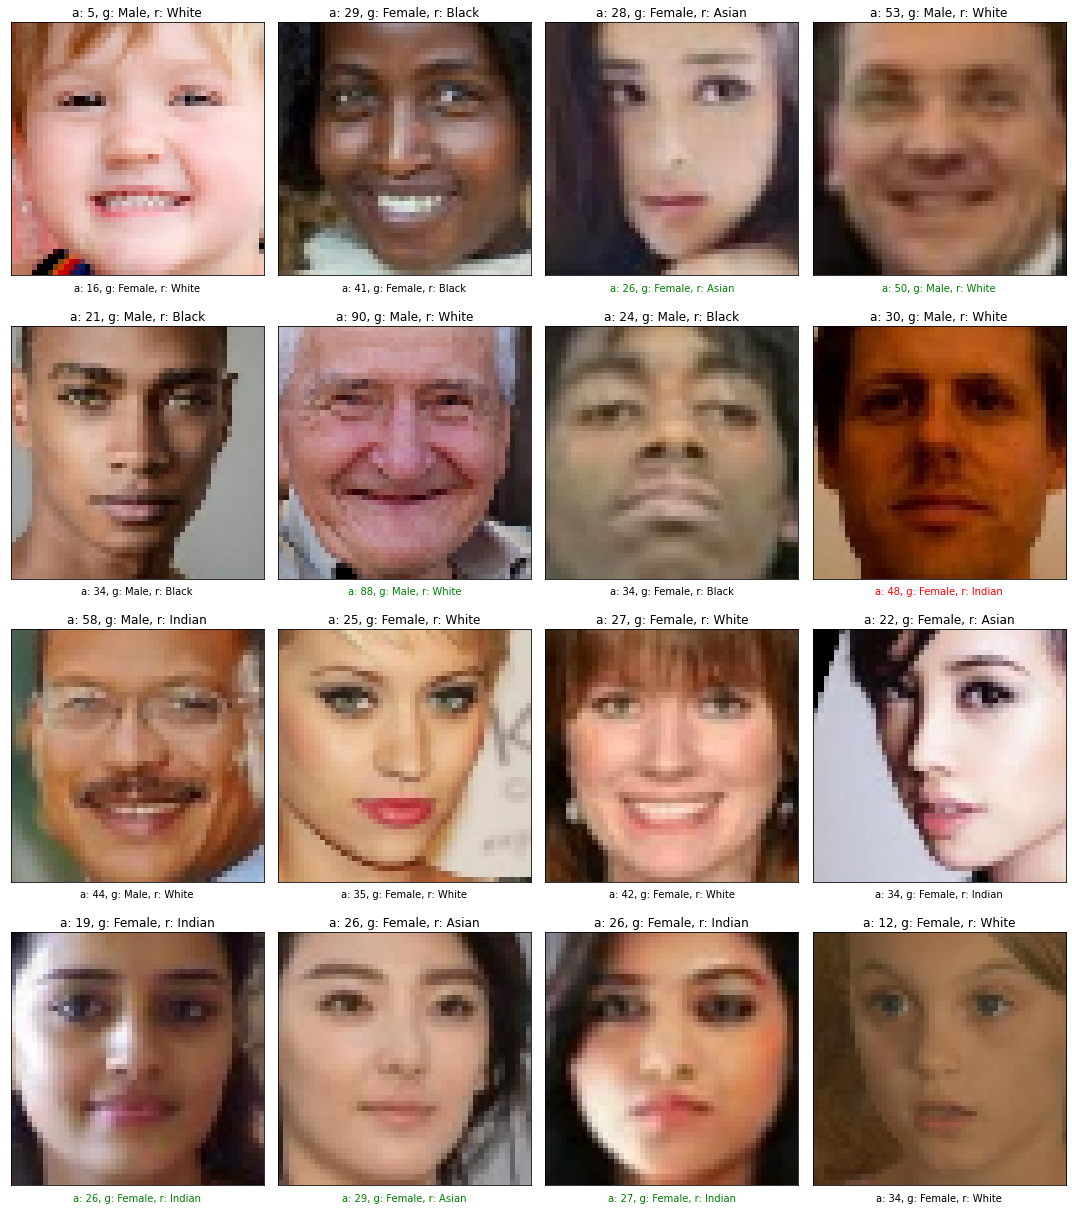

In [30]:
import math
n = 16
random_indices = np.random.permutation(n)
n_cols = 4
n_rows = math.ceil(n / n_cols)
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 17))
for i, img_idx in enumerate(random_indices):
    ax = axes.flat[i]
    ax.imshow(images[img_idx])
    
    cur_age_pred = age_pred[img_idx]
    cur_age_true = age_true[img_idx]
    
    cur_gender_pred = gender_pred[img_idx]
    cur_gender_true = gender_true[img_idx]
    
    cur_race_pred = race_pred[img_idx]
    cur_race_true = race_true[img_idx]
    
    age_threshold = 10
    if cur_gender_pred == cur_gender_true and cur_race_pred == cur_race_true and abs(cur_age_pred - cur_age_true) <= age_threshold:
        ax.xaxis.label.set_color('green')
    elif cur_gender_pred != cur_gender_true and cur_race_pred != cur_race_true and abs(cur_age_pred - cur_age_true) > age_threshold:
        ax.xaxis.label.set_color('red')
    
    ax.set_xlabel('a: {}, g: {}, r: {}'.format(int(age_pred[img_idx]),
                            dataset_dict['gender_id'][gender_pred[img_idx]],
                               dataset_dict['race_id'][race_pred[img_idx]]))
    
    ax.set_title('a: {}, g: {}, r: {}'.format(int(age_true[img_idx]),
                            dataset_dict['gender_id'][gender_true[img_idx]],
                               dataset_dict['race_id'][race_true[img_idx]]))
    ax.set_xticks([])
    ax.set_yticks([])
    
plt.tight_layout()
plt.savefig('predictions.png')